# Simple Fits 1

## PW and HO, beta1 > 0, beta2 > 0

- use the mean-field limit ODE for simple complete graph (fully connected case)

- synthetic tests:
  - use data from MF trajectory and fit MF to this
  
  - use data from Gillespie and fit MF

- play with least squares / grid search and abc potentially

- start antagonizing the estimation

- possibilities: only PW or only HO for MF model, by setting either beta1 = 0 or beta2 = 0

In [2]:
import numpy as np
import matplotlib.pylab as plt

import sys
sys.path.append('../src/')
from solve_kolmogorov import *
from simulate_gillespie import *
from Hypergraphs import *
from estimate_total_rates import *

from scipy.integrate import solve_ivp

## Setup

In [3]:
# -- Setup for 3 regimes from Figure 2 from Insights paper --
test_name = "simple_fits"

g_type = "complete"

N = 2500
g = CompleteHypergraph(N)

I0 = 500
nsims = 10

run_gillespie_simulations = False

time_max = 10

# 3 regimes
betas_unscaled_selected = [(3, 3), (3, 1.5), (1.5, 3)]
betas_unscaled = betas_unscaled_selected[0]
print(betas_unscaled)

beta1 = betas_unscaled[0] / N       # pairwise infection rate (tau = lambda / N)
beta2 = betas_unscaled[1] / (N**2)  # hyperedge contagion rate (beta = mu / N^2)
mu    = 1                           # recovery rate (gamma)

print(f"{test_name}: \n")
print(f"\t * H = Complete Hypergraph, N = {N}, I0 = {I0}, time_max = {time_max},")
print(f"\t * beta1 * N = {np.round(beta1 * N, 2)}")
print(f"\t * beta2 * N^2 = {np.round(beta2 * (N**2), 2)}")
print(f"\t * mu = {mu}")
print(f"\t * with estimation based on {nsims} Gillespie simulation runs\n")

(3, 3)
simple_fits: 

	 * H = Complete Hypergraph, N = 2500, I0 = 500, time_max = 10,
	 * beta1 * N = 3.0
	 * beta2 * N^2 = 3.0
	 * mu = 1
	 * with estimation based on 10 Gillespie simulation runs



## Run Gillespie

Normalize $X(t)$ curves `X_t[2] / N`, avg curve `avg_curve / N`, and $k^{*}$ `plt.axhline(y=int(0.75) ...`

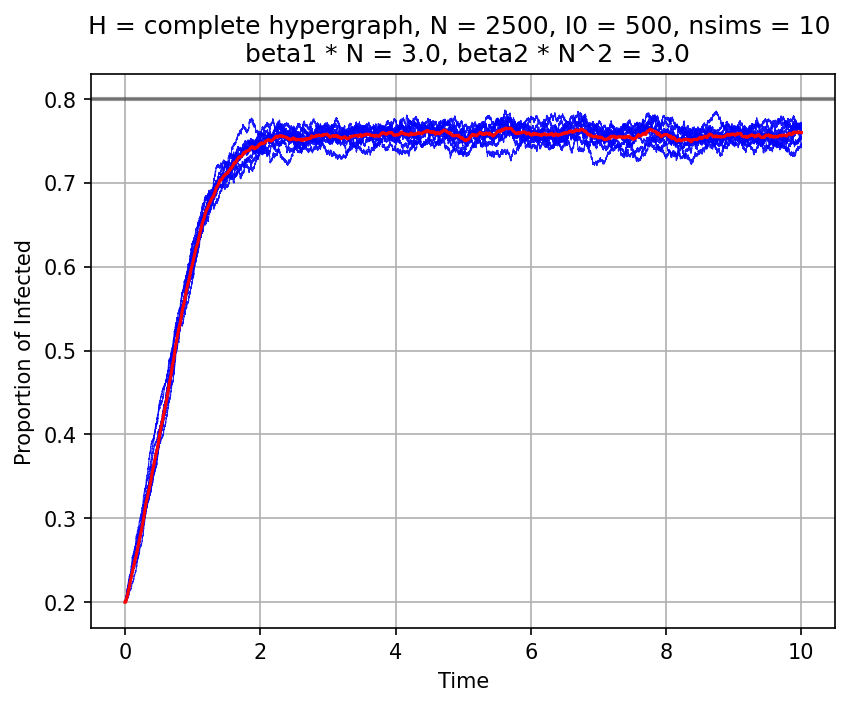

In [ ]:
## --- Run Gillespie ---
# I0_gillespie = I0 # TODO: go over the range when necessary
# initial_infections = list(range(I0_gillespie))
if run_gillespie_simulations: 
    X_sims = []
    for _ in range(nsims):
        # X_t = gillespie_sim(g, beta1, beta2, mu, initial_infections, time_max)
        X_t = gillespie_sim_complete(N, beta1, beta2, mu, I0, time_max)
        X_sims.append(X_t)

    # save the simulation results
    sim_results = {f'sim_{i}': X_sims[i] for i in range(nsims)}
    np.savez_compressed(f'../results/gillespie-sims_{test_name}.npz', **sim_results)
else: 
    # load simulation results
    sim_results = np.load(f'../results/gillespie-sims_{test_name}.npz', allow_pickle=True)
    X_sims = [sim_results[f'sim_{i}'] for i in range(nsims)]

# plot X_t curves in gray and average curve in red
fig = plt.figure(dpi=150) # set DPI!
ax  = plt.subplot()

for X_t in X_sims:
    ax.plot(X_t[0], X_t[2] / N, c="blue", alpha=0.9, linewidth=0.5, rasterized=True)

avg_curve, times = get_average(X_sims, time_max, nsims, delta_t = 0.01)
# avg_curve, times = get_average_corrected(X_sims, time_max, nsims, delta_t = 0.01)

plt.axhline(y=0.8, color='black', lw=2, alpha=0.4, linestyle='-')

plt.plot(times, avg_curve / N, "red")

plt.xlabel("Time")
plt.ylabel("Proportion of Infected")
plt.grid(True)

plt.title(f"H = complete hypergraph, N = {N}, I0 = {I0}, nsims = {nsims} \n beta1 * N = {np.round(beta1 * N, 2)}, beta2 * N^2 = {np.round(beta2 * (N**2), 2)}")

plt.savefig(f"../figures/estimation/complete/{test_name}/gillespie-sims.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()
plt.close(fig) # free up memory

## Solve mean-filed limit ODE and compare

For start:
- reproduce figure from Insights paper

### Equation 2.18 from Insights paper

Let $y(t)$ be the proportion of infected nodes $k / N$ at time $t$, then in the limit

$$
\begin{equation}
dy/dt = (\lambda - \gamma) y + (\mu / 2 - \lambda) y^2 - (\mu / 2) y^3
\tag{2.18}
\end{equation}
$$

Translating to our notation:
\begin{align*}
\beta_1 &\leftarrow \lambda \\
\beta_2 &\leftarrow  \mu \\ 
\mu &\leftarrow \gamma
\end{align*}

Equation 2.18 becomes

$$
\begin{equation}
dy/dt = (\beta_1 - \mu) y + (\beta_2 / 2 - \beta_1) y^2 - (\beta_2 / 2) y^3
\tag{2.18*}
\end{equation}
$$

where parameters are scaled such that 
\begin{align*}
\beta_1 &\leftarrow \beta_1 N \\
\beta_2 &\leftarrow \beta_2 N^2
\end{align*}


In [5]:
# assuming complete hypergraph
def mean_field_ode(t, y, beta1_scaled, beta2_scaled, mu_recovery):
    r"""Mean-field ODE dy/dt for SIS model on complete hypergraph: 
    Equation 2.18 from Insights from exact social contagion dynamics on 
    networks with higher-order structures, Kiss et al. 2023.
    """
    dydt = (beta1_scaled - mu_recovery) * y \
        + (beta2_scaled / 2.0 - beta1_scaled) * y**2 \
        - (beta2_scaled / 2.0) * y**3
    return dydt

In [6]:
def solve_mean_field(N, I0, beta1_true, beta2_true, mu_recovery, time_max, num_steps=101):
    beta1_scaled = beta1_true * N
    beta2_scaled = beta2_true * (N**2)
    
    # initial condition is proportion of infected
    y0 = I0 / N

    # time span and evaluation points
    t_span = (0.0, time_max)
    t_eval = np.linspace(t_span[0], t_span[1], num_steps)

    # solve the ODE using LSODA
    sol = solve_ivp(
        mean_field_ode,
        t_span,
        [y0],
        method='LSODA',
        t_eval=t_eval,
        args=(beta1_scaled, beta2_scaled, mu_recovery)
    )
    return sol

In [7]:
print(f"Unscaled (beta1, beta2, mu) =  {tuple(np.round([beta1 * N, beta2 * (N**2), mu], 2))}")

Unscaled (beta1, beta2, mu) =  (np.float64(3.0), np.float64(3.0), np.float64(1.0))


In [8]:
mf_sol = solve_mean_field(N, I0, beta1, beta2, mu, time_max)

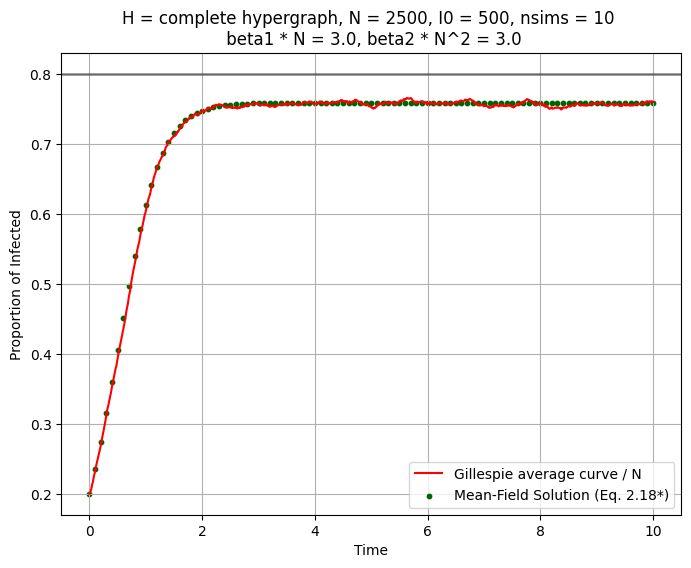

In [ ]:
# plot both the MF solution and Gillespie average curve / N
plt.figure(figsize=(8, 6))

plt.plot(times, avg_curve / N, 'red', label="Gillespie average curve / N")

plt.scatter(mf_sol.t, mf_sol.y[0], marker='o', s = 10, 
    color = "darkgreen", alpha = 1, label='Mean-Field Solution (Eq. 2.18*)')

plt.axhline(y=0.8, color='black', lw=2, alpha=0.4, linestyle='-')

plt.xlabel("Time")
plt.ylabel("Proportion of Infected")
plt.legend()
plt.grid(True)

plt.title(f"H = complete hypergraph, N = {N}, I0 = {I0}, nsims = {nsims} \n beta1 * N = {np.round(beta1 * N, 2)}, beta2 * N^2 = {np.round(beta2 * (N**2), 2)}")
plt.savefig(f"../figures/estimation/complete/{test_name}/mf-solution-vs-gillespie.pdf", 
            format='pdf', bbox_inches='tight')

plt.show()

# Simplest fits

Find $\widehat{\beta}_{1}, \widehat{\beta}_{2}$ that best fit:

1. MF data `mf_sol.y[0]`

2. Gillespie average data `avg_curve / N`

3. One run of Gillespie `X(t) / N`

4. ...?

Using simple methods: 

- least squares, grid search, ...

- probably just `scipy.optimize.curve_fit` has it all


# Simple fitting - Task 1

In [35]:
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit

In [36]:
def solve_mf_for_fit(t_eval, beta1_scaled, beta2_scaled):
    r""" Wrapper for curve_fit that solves MF ODE given scaled parameters:
      * t_eval: time points of the input data
      * beta1, beta2: scaled parameters
      * N, I0, mu: are taken from global scope
      TODO: could pass them all via list or dict
    """
    # solve ODE with current fitted param values
    # evaluate at the same time points as the input data
    y0 = I0 / N
    t_span = (t_eval[0], t_eval[-1])

    sol = solve_ivp(
        mean_field_ode,
        t_span,
        [y0],
        method='LSODA',
        t_eval=t_eval,
        args=(beta1_scaled, beta2_scaled, mu_recovery)
    )
    return sol.y[0]

In [37]:
def fit_mf_to_data(t_data, y_data, initial_guess):
    r""" Fits MF ODE to given:
      * time points t_data
      * observed proportion of infected y_data
      * initial_guess (beta1, beta2)
    """
    print(f"Initial guess: beta1 = {initial_guess[0]:.4f}, beta2 = {initial_guess[1]:.4f}")
    param_bounds = ([0, 0], [np.inf, np.inf]) # lower and upper bounds

    popt, pcov = curve_fit(
        solve_mf_for_fit, # function generating the model curve
        t_data,           # time points
        y_data,           # target variable (data to fit)
        p0=initial_guess,
        bounds=param_bounds,
        method='trf',      # TODO: put method to args 'trf' is good with bounds
        max_nfev=1000      # maximum number of function evaluations
        # jac=...          # TODO: Jacobian can be provided!
    )
    print("done")
    return popt, pcov

In [38]:
# extract data from true MF model
t_data_mf = mf_sol.t
y_data_mf = mf_sol.y[0]

# initial guess

# beta1 = betas_unscaled[0] / N       # pairwise infection rate (tau = lambda / N)
# beta2 = betas_unscaled[1] / (N**2)  # hyperedge contagion rate (beta = mu / N^2)

# TODO: use scaled parameters
beta1_scaled = beta1 * N
beta2_scaled = beta2 * (N**2)
print(f"True parameters: beta1_scaled = {beta1_scaled:.4f}, beta2_scaled = {beta2_scaled:.4f}")

# TODO: start with guess close to true values
# guess_beta1 = beta1_scaled * 0.8
# guess_beta2 = beta2_scaled * 1.2

guess_beta1 = beta1_scaled * 2
guess_beta2 = beta2_scaled * 0.1
print(f"Initial guess: guess_beta2 = {guess_beta1:.4f}, guess_beta2 = {guess_beta2:.4f}")

initial_params_guess = [guess_beta1, guess_beta2]

True parameters: beta1_scaled = 3.0000, beta2_scaled = 3.0000
Initial guess: guess_beta2 = 6.0000, guess_beta2 = 0.3000


In [39]:
# N, I0, mu = mu_recovery: are taken from global scope
# TODO: could pass them all via list or dict
mu_recovery = mu
N, I0, mu_recovery

(2500, 500, 1)

In [40]:
fitted_params, covariance = fit_mf_to_data(t_data_mf, y_data_mf, initial_params_guess)

Initial guess: beta1 = 6.0000, beta2 = 0.3000
done


In [41]:
# check results
beta1_hat, beta2_hat = fitted_params
print(f"finished with: beta1_hat = {beta1_hat:.4f}, beta2_hat = {beta2_hat:.4f}")

finished with: beta1_hat = 3.0000, beta2_hat = 3.0000


**Task 1 = Success: Seems like we can recover parameters very accurately given data from actual model.**

# Simple fitting - Task 2

In [42]:
delta_t = 0.01
avg_curve, times = get_average(X_sims, time_max, nsims, delta_t)
len(avg_curve / N), time_max / delta_t + 1

(1001, 1001.0)

In [43]:
y_data_gillespie_avg_full = avg_curve / N
t_data_gillespie_avg_full = times

In [44]:
# let's make it more realistic
# MF ODE produces a smooth curve
# we can capture the shape with fewer points, 50?
# probably no real-world data set is sampled at this frequency (time_max = 10)..
# let's sub sample the avg_curve
# take every subsample_step point
subsample_step = 20 # every 20th point
t_data = t_data_gillespie_avg_full[::subsample_step]
y_data = y_data_gillespie_avg_full[::subsample_step]
print(f"Fitting to {len(t_data)} sampled points from average Gillespie curve")


Fitting to 51 sampled points from average Gillespie curve


In [45]:
# TODO: start with guess close to true values
# guess_beta1 = beta1_scaled * 0.8
# guess_beta2 = beta2_scaled * 1.2

guess_beta1 = beta1_scaled * 2
guess_beta2 = beta2_scaled * 0.1
print(f"Initial guess: guess_beta2 = {guess_beta1:.4f}, guess_beta2 = {guess_beta2:.4f}")

initial_params_guess = [guess_beta1, guess_beta2]

Initial guess: guess_beta2 = 6.0000, guess_beta2 = 0.3000


In [46]:
fitted_params, covariance = fit_mf_to_data(t_data, y_data, initial_params_guess)
beta1_hat, beta2_hat = fitted_params
std_errors = np.sqrt(np.diag(covariance))

beta1_hat, beta2_hat, std_errors

Initial guess: beta1 = 6.0000, beta2 = 0.3000
done


(np.float64(2.9029572131154033),
 np.float64(3.214440596260229),
 array([0.01966336, 0.06335154]))

In [ ]:
print("Fit results (to sampled avgerage Gillespie): ")
print(f"\tTrue beta1: {beta1_scaled:.2f}")
print(f"\tbeta1_hat: {beta1_hat:.6f} +/- {beta1_se:.6f}\n")

print(f"\tTrue beta2: {beta1_scaled:.2f}")
print(f"\tbeta2_hat: {beta2_hat:.10f} +/- {beta2_se:.10f}")

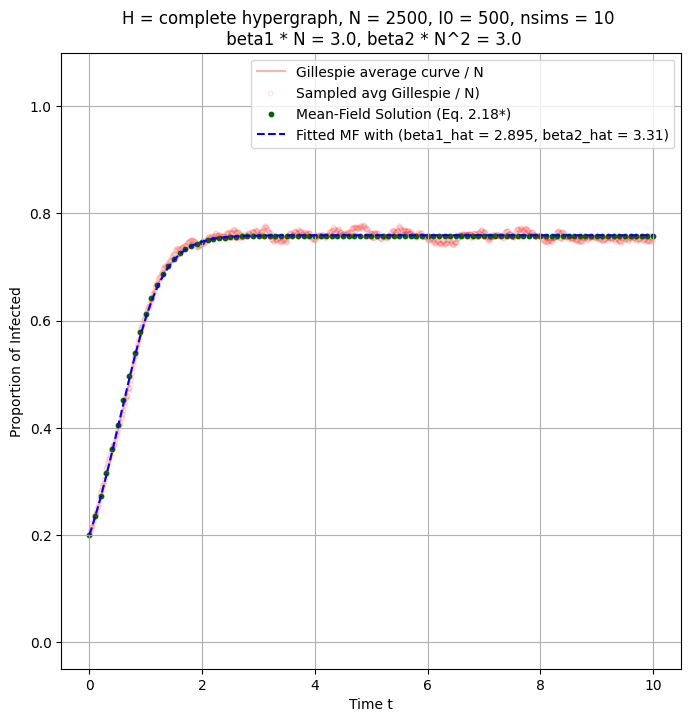

In [ ]:
# plot model fit
plt.figure(figsize=(8, 8))

# full gillespie avg
plt.plot(t_data_gillespie_avg_full, y_data_gillespie_avg_full, 
    'r-', alpha=0.3, label='Gillespie average curve / N')

# sub sampled data points used for fitting
plt.scatter(t_data, y_data, label='Sampled avg Gillespie / N)', marker='o', s=10, alpha = 0.1,
    facecolors='none', edgecolors='r')

# true MF solution
plt.scatter(mf_sol.t, mf_sol.y[0], marker='o', s = 10, 
    color = "darkgreen", alpha = 1, label='Mean-Field Solution (Eq. 2.18*)')

# fitted curve using the estimated parameters over the full grid
t_span = (0, time_max)
t_fit_curve_eval = np.linspace(t_span[0], t_span[1], 201) # smooth curve
y_fit_curve = solve_mf_for_fit(t_fit_curve_eval, beta1_hat, beta2_hat)

plt.plot(t_fit_curve_eval, y_fit_curve, 'b--', 
    label=f'Fitted MF with (beta1_hat = {beta1_hat:.3f}, beta2_hat = {beta2_hat:.3g})')

plt.xlabel("Time t")
plt.ylabel("Proportion of Infected")

plt.legend()
plt.grid(True)

plt.ylim(bottom=-0.05, top=1.1)

plt.title(f"H = complete hypergraph, N = {N}, I0 = {I0}, nsims = {nsims} \n beta1 * N = {np.round(beta1 * N, 2)}, beta2 * N^2 = {np.round(beta2 * (N**2), 2)}")

plt.savefig(f"../figures/estimation/complete/{test_name}/fit2.pdf", format='pdf', bbox_inches='tight')

plt.show()

**Task 2 = Success: Seems like we can recover parameters very accurately given sampled average gillespie.**

## Simple fitting - Task 3

In [48]:
nsims # we have 10 simulation runs with number of events:
[len(X_t[0]) for X_t in X_sims]

[36835, 37685, 37285, 37586, 37003, 37586, 37250, 37475, 37040, 37280]

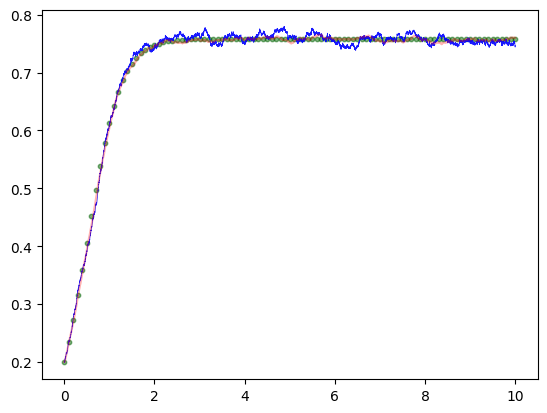

In [49]:
nsim = 3
X_t = X_sims[nsim]
plt.plot(X_t[0], X_t[2] / N, c="blue", alpha=0.9, linewidth=0.5, rasterized=True)

plt.plot(t_data_gillespie_avg_full, y_data_gillespie_avg_full, 
    'r-', alpha=0.3, label='Gillespie average curve / N')

plt.scatter(mf_sol.t, mf_sol.y[0], marker='o', s = 10, 
    color = "darkgreen", alpha = 0.5, label='Mean-Field Solution (Eq. 2.18*)')

plt.show()

In [50]:
# extract time and states (proportions) from single run
run_index_to_fit = 3
X_t_single = X_sims[run_index_to_fit]

t_single_raw = X_t_single[0, :].astype(np.float64)     # cast time to float!
y_single_raw = X_t_single[2, :].astype(np.float64) / N # cast state to float and divide by N!

In [51]:
# interpolate into a regular grid
delta_t = 0.01 # dense grid
times = np.arange(0, time_max + delta_t, delta_t)
t_data = times 
t_data

array([ 0.  ,  0.01,  0.02, ...,  9.98,  9.99, 10.  ])

In [52]:
from scipy.interpolate import interp1d

interp_func = interp1d(t_single_raw, y_single_raw, kind='previous',
                       bounds_error=False, fill_value=(y_single_raw[0], y_single_raw[-1]))
# interpolated k / N data at regular time points
y_data = interp_func(t_data)
y_data

array([0.2   , 0.2012, 0.2056, ..., 0.7528, 0.7512, 0.7472])

In [53]:
# TODO: start with guess close to true values
guess_beta1 = beta1_scaled * 0.8
guess_beta2 = beta2_scaled * 1.2

# guess_beta1 = beta1_scaled * 2
# guess_beta2 = beta2_scaled * 0.1
print(f"Initial guess: guess_beta2 = {guess_beta1:.4f}, guess_beta2 = {guess_beta2:.4f}")

initial_params_guess = [guess_beta1, guess_beta2]

Initial guess: guess_beta2 = 2.4000, guess_beta2 = 3.6000


In [ ]:
fitted_params, covariance = fit_mf_to_data(t_data, y_data, initial_params_guess)

beta1_hat, beta2_hat = fitted_params
std_errors = np.sqrt(np.diag(covariance))
beta1_se, beta2_se = std_errors

Initial guess: beta1 = 2.4000, beta2 = 3.6000
done


In [55]:
print("Fit results (to a single Gillespie run): ")
print(f"\tTrue beta1: {beta1_scaled:.2f}")
print(f"\tbeta1_hat: {beta1_hat:.6f} +/- {beta1_se:.6f}\n")

print(f"\tTrue beta2: {beta1_scaled:.2f}")
print(f"\tbeta2_hat: {beta2_hat:.10f} +/- {beta2_se:.10f}")

Fit results (to a single Gillespie run): 
	True beta1: 3.00
	beta1_hat: 2.895030 +/- 0.010711

	True beta2: 3.00
	beta2_hat: 3.3146469093 +/- 0.0345792814


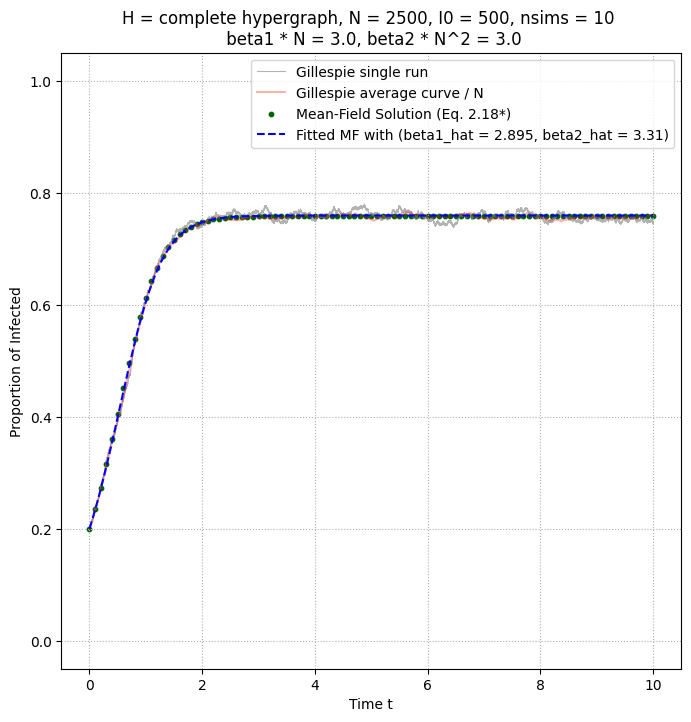

In [ ]:
plt.figure(figsize=(8, 8))

# single run raw data
plt.plot(X_t_single[0], X_t_single[2].astype(float) / N, c="grey", alpha=0.6,
            linewidth=0.8, label=f'Gillespie single run')

# avg gillespie curve
y_data_gillespie_avg_full = avg_curve / N
t_data_gillespie_avg_full = times
plt.plot(t_data_gillespie_avg_full, y_data_gillespie_avg_full, 
    'r-', alpha=0.3, label='Gillespie average curve / N')

# true MF solution
plt.scatter(mf_sol.t, mf_sol.y[0], marker='o', s = 10, 
    color = "darkgreen", alpha = 1, label='Mean-Field Solution (Eq. 2.18*)')

# fitted MF curve based on single gillespie run fit
t_span = (0, time_max)
t_fit_curve_eval = np.linspace(t_span[0], t_span[1], 201) # smooth curve
y_fit_curve = solve_mf_for_fit(t_fit_curve_eval, beta1_hat, beta2_hat)

plt.plot(t_fit_curve_eval, y_fit_curve, 'b--', 
    label=f'Fitted MF with (beta1_hat = {beta1_hat:.3f}, beta2_hat = {beta2_hat:.3g})')

plt.xlabel("Time t")
plt.ylabel("Proportion of Infected")

plt.legend(loc='best')
plt.grid(True, linestyle=':')

plt.ylim(bottom=-0.05, top=1.05)

plt.title(f"H = complete hypergraph, N = {N}, I0 = {I0}, nsims = {nsims} \n beta1 * N = {np.round(beta1 * N, 2)}, beta2 * N^2 = {np.round(beta2 * (N**2), 2)}")

plt.savefig(f"../figures/estimation/complete/{test_name}/fit3.pdf", format='pdf', bbox_inches='tight')


plt.show()

# TODO: start antagonizing the estimation

- Try with possibilities: PW, HO for MF model, by setting either beta1 = 0 or beta2 = 0